In [32]:
import os
import numpy as np
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.patches import Polygon
from IPython.display import HTML
import tools 


In [33]:
def compute_team_dimensions(df_b, df_o, sport):
    print(f'Calculating Width and Length | {sport.capitalize()}')
    df_b = df_b.dropna().copy()
    df_o = df_o.dropna().copy()

    # Get player IDs for both teams
    blue_ids = tools.get_team_list(sport, 'blue')
    orange_ids = tools.get_team_list(sport, 'orange')

    # Construct column names
    blue_x_cols = [f"{pid}_x" for pid in blue_ids]
    blue_y_cols = [f"{pid}_y" for pid in blue_ids]
    orange_x_cols = [f"{pid}_x" for pid in orange_ids]
    orange_y_cols = [f"{pid}_y" for pid in orange_ids]

    # Initialize new columns
    df_b['width_blue'] = np.nan
    df_b['length_blue'] = np.nan
    df_o['width_orange'] = np.nan
    df_o['length_orange'] = np.nan

    n = min(len(df_b), len(df_o))  # Ensure synchronized iteration

    for i in range(n):
        # BLUE team
        bx = df_b.loc[i, blue_x_cols].values.astype(float)
        by = df_b.loc[i, blue_y_cols].values.astype(float)

        if np.isfinite(bx).sum() >= 2 and np.isfinite(by).sum() >= 2:
            df_b.loc[i, 'width_blue'] = np.nanmax(bx) - np.nanmin(bx)
            df_b.loc[i, 'length_blue'] = np.nanmax(by) - np.nanmin(by)
            df_b.loc[i, 'min_x_blue'] = np.nanmin(bx)
            df_b.loc[i, 'max_x_blue'] = np.nanmax(bx)
            df_b.loc[i, 'min_y_blue'] = np.nanmin(by)
            df_b.loc[i, 'max_y_blue'] = np.nanmax(by)

        # ORANGE team
        ox = df_o.loc[i, orange_x_cols].values.astype(float)
        oy = df_o.loc[i, orange_y_cols].values.astype(float)

        if np.isfinite(ox).sum() >= 2 and np.isfinite(oy).sum() >= 2:
            df_o.loc[i, 'width_orange'] = np.nanmax(ox) - np.nanmin(ox)
            df_o.loc[i, 'length_orange'] = np.nanmax(oy) - np.nanmin(oy)
            df_o.loc[i, 'min_x_orange'] = np.nanmin(ox)
            df_o.loc[i, 'max_x_orange'] = np.nanmax(ox)
            df_o.loc[i, 'min_y_orange'] = np.nanmin(oy)
            df_o.loc[i, 'max_y_orange'] = np.nanmax(oy)

    return df_b, df_o

In [ ]:
def create_width_length_video(df_b, df_o, sport, save=True):
    print(f'Creating Width/Length Video | {sport.capitalize()}')

    blue_ids = tools.get_team_list(sport, 'blue')     
    orange_ids = tools.get_team_list(sport, 'orange')

    blue_cols = [f'{pid}_{axis}' for pid in blue_ids for axis in ['x', 'y']]
    orange_cols = [f'{pid}_{axis}' for pid in orange_ids for axis in ['x', 'y']]

    # Setup figure and field
    fig, ax = tools.draw_field_court(sport)
    scat_blue = ax.scatter([], [], s=50, color='blue')
    scat_orange = ax.scatter([], [], s=50, color='orange')

    # Width and length lines
    line_width_blue, = ax.plot([], [], 'b--', linewidth=2)
    line_length_blue, = ax.plot([], [], 'b-', linewidth=2)
    line_width_orange, = ax.plot([], [], 'orange', linestyle='--', linewidth=2)
    line_length_orange, = ax.plot([], [], 'orange', linewidth=2)

    # Text annotations
    text_blue = ax.text(0.03, 0.95, '', transform=ax.transAxes, fontsize=12, color='black')
    text_orange = ax.text(0.53, 0.95, '', transform=ax.transAxes, fontsize=12, color='black')

    def update(frame):
        # Posições
        blue_coords = list(zip(df_b.loc[frame, blue_cols[::2]], df_b.loc[frame, blue_cols[1::2]]))
        orange_coords = list(zip(df_o.loc[frame, orange_cols[::2]], df_o.loc[frame, orange_cols[1::2]]))

        # Atualiza posições dos atletas
        scat_blue.set_offsets(blue_coords)
        scat_orange.set_offsets(orange_coords)

        # Pequeno offset visual para separação da linha do campo
        if sport == 'soccer': 
            s = 2 
        else: 
            s = 1
        offset_y_top = ax.get_ylim()[1] - s
        offset_y_bottom = ax.get_ylim()[0] + s
        offset_x_left = ax.get_xlim()[0] + s
        offset_x_right = ax.get_xlim()[1] - s

        # BLUE – largura (em cima)
        min_x_b = df_b.loc[frame, 'min_x_blue']
        max_x_b = df_b.loc[frame, 'max_x_blue']
        line_width_blue.set_data([min_x_b, max_x_b], [offset_y_top, offset_y_top])

        # BLUE – comprimento (na esquerda)
        min_y_b = df_b.loc[frame, 'min_y_blue']
        max_y_b = df_b.loc[frame, 'max_y_blue']
        line_length_blue.set_data([offset_x_left, offset_x_left], [min_y_b, max_y_b])

        # ORANGE – largura (embaixo)
        min_x_o = df_o.loc[frame, 'min_x_orange']
        max_x_o = df_o.loc[frame, 'max_x_orange']
        line_width_orange.set_data([min_x_o, max_x_o], [offset_y_bottom, offset_y_bottom])

        # ORANGE – comprimento (na direita)
        min_y_o = df_o.loc[frame, 'min_y_orange']
        max_y_o = df_o.loc[frame, 'max_y_orange']
        line_length_orange.set_data([offset_x_right, offset_x_right], [min_y_o, max_y_o])

        # Text updates
        w_b = df_b.loc[frame, 'width_blue']
        l_b = df_b.loc[frame, 'length_blue']
        w_o = df_o.loc[frame, 'width_orange']
        l_o = df_o.loc[frame, 'length_orange']
        text_blue.set_text(f'Blue | W: {w_b:.2f}m | L: {l_b:.2f}m')
        text_orange.set_text(f'Orange | W: {w_o:.2f}m | L: {l_o:.2f}m')

        return (
            scat_blue, scat_orange,
            line_width_blue, line_length_blue,
            line_width_orange, line_length_orange,
            text_blue, text_orange
        )

    min_frames = min(len(df_b), len(df_o))
    anim = FuncAnimation(fig, update, frames=range(0, min_frames, 2), interval=40, blit=True)
    writer = FFMpegWriter(fps=30)

    if save:
        folder_dir = f'results/width_length/{sport}/'
        os.makedirs(folder_dir, exist_ok=True)
        print(f'    Saving video: {folder_dir}{sport}.mp4')
        anim.save(f'{folder_dir}{sport}.mp4', writer=writer)

    return anim

In [35]:
def calculate_width_length(sport, variable='width_length', save=True):
    df_b, df_o = tools.load_data(sport)
    df_b, df_o = compute_team_dimensions(df_b, df_o, sport)
    anim = create_width_length_video(df_b, df_o, sport, save=True)

    if save == True:
        folder_dir = f'results/{variable}/{sport}/'
        print(f'    Saving data: {folder_dir}{sport}_blue.csv')
        df_b.to_csv(f'{folder_dir}{sport}_blue.csv',index=False)
        print(f'    Saving data: {folder_dir}{sport}_orange.csv')
        df_o.to_csv(f'{folder_dir}{sport}_orange.csv',index=False)
    return df_b, df_o, anim

Loading XY data: Basketball
Calculating Width and Length | Basketball
Creating Width/Length Video | Basketball
    Saving video: results/width_length/basketball/basketball.mp4
    Saving data: results/width_length/basketball/basketball_blue.csv
    Saving data: results/width_length/basketball/basketball_orange.csv


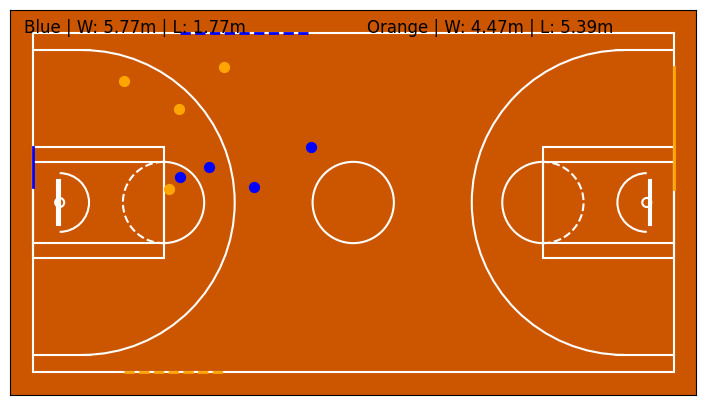

In [36]:
sport = 'basketball' #soccer, basketball, volleyball
df_b, df_o, anim = calculate_width_length(sport)

In [ ]:
# Create video on .ipynb
HTML(anim.to_html5_video()) 